In policy gradients, the objective is to learn a parameter $\theta^*$ that
maximizes the following objective:

\begin{equation}
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta(\tau)}[R(\tau)]
\end{equation}

where $\tau = (s_1,a_1,s_2,\ldots,s_{T-1},a_{T-1},s_T)$ is a *trajectory*
(also referred to as an *episode*), and factorizes as

\begin{equation}
\pi_\theta(\tau) = p(s_1)\pi_\theta(a_1|s_1)\prod_{t=2}^{T} p(s_t|s_{t-1},a_{t-1})\pi_\theta(a_t|s_t)
\end{equation}

and $R(\tau)$ denotes the full trajectory reward $R(\tau) = \sum_{t=1}^{T}
r(s_t,a_t)$ with $r(s_t,a_t)$ the rewards at the individual time steps.

In policy gradients, we directly apply the gradient $\nabla_\theta$ to
$J(\theta)$. In order to do so, we require samples of trajectories, meaning that
we now denote them as $\tau_i$ for the $i$th trajectory, and have $\tau_i =
(s_{i1},a_{i1},s_{i2},\ldots,s_{iT})$. When we approximate the gradient with
samples, we get:

\begin{align*}
\nabla_\theta J(\theta) &\approx \frac{1}{N} \sum_{i=1}^N \nabla_\theta \log \pi_\theta(\tau_i) R(\tau_i) \\
&= \frac{1}{N}\sum_{i=1}^N \left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right)  \left( \sum_{t=1}^{T} r(s_{it},a_{it}) \right)
\end{align*}

Multiplying a discount factor $\gamma$ to the rewards can be interpreted as
encouraging the agent to focus on rewards closer in the future, which can also
be thought of as a means for reducing variance (because there are more
possible futures further into the future). The discount factor can be
incorporated in two ways, from the full trajectory:

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t=1}^T \gamma^{t-1} r(s_{it},a_{it}) \right)
\end{equation}

and from the reward to go:

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t'=t}^T \gamma^{t'-t} r(s_{it},a_{it}) \right)
\end{equation}

we only focus on the first version: full tragectory.



# Policy Gradients Implementation


- Set Up Hyperparameters and environment.
- Build a MLP model for policy learning.
- Initialize the agent, such as define the policy network and optimizer.
- Forward Computation: Sample trajectories by conducting an action given an observation from the environment, and calculate sum of rewards in each trajectory, That includes `sample_action`, `sample_trajectory`, `sample_trajectories` and `sum_of_rewards`.
- Backward Computation: Optimize the policy network based on the update rule. That contains `compute_advantage`, `estimate_return`, `get_log_prob` , `update_parameters`.

## Problem 1: data sampling

You need to implement any parts with a "Problem 1" header in the code. Here's what you need to do:

- 1. Implement `sample_action`, which samples an action from $\pi_\theta(a|s)$. This operation will be called in `sample_trajectories`.
- 2. Implement `sample_trajectory`, you need to call `sample_action` to obtain current action.
- 3. Implement `sum_of_rewards`, which is the Monte Carlo estimation of the Q function. You need to estimate the q-value of each path and return a single vector for the estimated q values whose length is the sum of the lengths of the paths.

## Problem 2: apply policy gradient
You only need to implement the parts with the "Problem 2" header.

- **Estimate return**: in `estimate_return`, normalize the advantages to have a mean of zero and a standard deviation of one.  This is a trick for reducing variance.
- Implement `get_log_prob` to obtain $\log \pi_\theta(a_{it}|s_{it})$: Given an action that the agent took in the environment, this computes the log probability of that action under $\pi_\theta(a|s)$. This will be used in the parameters update: 

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t=1}^T \gamma^{t-1} r(s_{it},a_{it}) \right)
\end{equation}

- **Update parameters**: In `update_parameters`, using the update operation `optimizer.step()` to update the parameters of the policy. You firstly need to create loss value with the inputs.



# Environment Introduction: 


##[CartPole-v0](https://gym.openai.com/envs/CartPole-v0/): 
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077). A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

### Observation Space
The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:

| Num | Observation           | Min                  | Max                |
|-----|-----------------------|----------------------|--------------------|
| 0   | Cart Position         | -4.8*                |  4.8*                |
| 1   | Cart Velocity         | -Inf                 | Inf                |
| 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
| 3   | Pole Angular Velocity | -Inf                 | Inf                 |

- `*`: the cart x-position can be observed between `(-4.8, 4.8)`, but an episode terminates if the cart leaves the
    `(-2.4, 2.4)` range.
- `**`: Similarly, the pole angle can be observed between  `(-.418, .418)` radians or precisely **±24°**, but an episode is
    terminated if the pole angle is outside the `(-.2095, .2095)` range or precisely **±12°**

### Action Space
The agent take a 1-element vector for actions.
The action space is `(action)` in `[0, 1]`, where `action` is used to push
the cart with a fixed amount of force:

| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing.
This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Rewards
Reward is 1 for every step taken, including the termination step.
### Starting State
All observations are assigned a uniform random value between (-0.05, 0.05).
### Episode Termination
The episode terminates of one of the following occurs:
1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200. 


In [1]:
!pip install gym==0.10.5

In [2]:
# Install gym-snake
!pip install -e ./Gym-Snake-master/

Obtaining file:///G:/Git/NUS_MComp/CS5446/cs5446_grp_proj/Gym-Snake-master
  Attempting uninstall: gym-snake
    Found existing installation: gym-snake 0.0.1
    Uninstalling gym-snake-0.0.1:
      Successfully uninstalled gym-snake-0.0.1
  Running setup.py develop for gym-snake


In [3]:
import numpy as np
import gym
import gym_snake
import os
import time
import inspect
import sys
from multiprocessing import Process
import torch
from torch import nn as nn
import torch.nn.functional as F

## Set Up Hyperparameters

In [4]:
env_name = 'snake-v0'
# exp_name = 'vpg'
render = False
animate = render
discount = 1.0
n_iter = 501
batch_size = 1000
ep_len = -1.
learning_rate = 1e-2
reward_to_go = False
dont_normalize_advantages = False
seed = 1
n_experiments = 1
max_path_length = 1e3
min_timesteps_per_batch = batch_size
gamma = discount
normalize_advantages = not(dont_normalize_advantages)

## Set Up Environment

In [5]:
#========================================================================================#
# Set Up Env
#========================================================================================#

# Make the gym environment
env = gym.make(env_name)

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Is this env continuous, or self.discrete? In this assignment, we only consider discrete action space.
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Observation and action sizes
ob_dim = 15*15*3
ac_dim = env.action_space.n if discrete else env.action_space.shape[0]
print(ac_dim)

4


G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Build a MLP model for policy learning.

In [6]:
class MLP(nn.Module):

    def __init__(self, input_size, num_actions):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.pool1  = nn.MaxPool2d(10,10)
        self.dense1 = nn.Linear(input_size, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, num_actions)

    def forward(self, x):
        x = self.pool1(x)
        x = x.view(-1, self.input_size)
        x = F.tanh(self.dense1(x))
        x = F.tanh(self.dense2(x))
        out = F.softmax(self.dense3(x))
        return out


## Initialize Agent
    

In [7]:
policy_net = MLP(input_size=ob_dim, num_actions=ac_dim)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)


## Data Sampling

In [8]:
def sample_action(policy_parameters):
    """
    Stochastically sampling from the policy distribution

    arguments:
        policy_parameters: logits of a categorical distribution over actions
                sy_logits_na: (batch_size, self.ac_dim)

    returns:
        sy_sampled_ac: (batch_size,)
    """

    #========================================================================================#
    #                           ----------PROBLEM 1----------
    #========================================================================================#
    # Stochastically sampling an action from the policy distribution $\pi_\theta(a|s)$.
    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    #expects dim = (batch_size, 4)
    
    sy_sampled_ac = torch.multinomial(policy_parameters, 1)

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

    return sy_sampled_ac

In [9]:
sample_input = torch.Tensor([[0.4,0.6, 1.5], [1.0, 4.0, 3.0]])
sampled_acs = sample_action(sample_input)
print(sampled_acs)

tensor([[2],
        [0]])


In [10]:
# TODO: define dimension of observation
print(ob_dim)
print(ac_dim)

675
4


In [11]:
def sample_trajectory(env):
    ob = env.reset()
    obs, acs, rewards = [], [], []
    steps = 0
    while True:

        ob_format = np.zeros((len(ob[0, 0]), len(ob), len(ob[0])), dtype=int)
        ob_format[0, :, :] = ob[:, :, 0]
        ob_format[1, :, :] = ob[:, :, 1]
        ob_format[2, :, :] = ob[:, :, 2]
        obs.append(ob_format)
        #====================================================================================#
        #                           ----------PROBLEM 1----------
        #====================================================================================#
        # obtain the action 'ac' for current observation 'ob'
        # ------------------------------------------------------------------
        # START OF YOUR CODE
        # ------------------------------------------------------------------
        ob_format = torch.Tensor(ob_format)

        distribution = policy_net(torch.unsqueeze(ob_format, 0))
        ac = sample_action(distribution)

        # ------------------------------------------------------------------
        # END OF YOUR CODE
        # ------------------------------------------------------------------
        ac = ac.numpy()[0]
        acs.append(ac)
        ob, rew, done, _ = env.step(ac)
        rewards.append(rew)
        steps += 1
        if done or steps > max_path_length:
            break
    path = {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32)}
    return path, steps


In [12]:
def sample_trajectories(itr, env):
    """Collect paths until we have enough timesteps, as determined by the
    length of all paths collected in this batch.
    """
    timesteps_this_batch = 0
    paths = []
    steps_list = []
    while True:
        path, steps= sample_trajectory(env)
        paths.append(path)
        steps_list.append(steps)
        timesteps_this_batch += len(path["reward"])
        if timesteps_this_batch > min_timesteps_per_batch:
            break
    return paths, timesteps_this_batch, steps_list

In [13]:
sample_trajectories(1, env)

G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


([{'observation': array([[[[  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            ...,
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.]],
   
           [[255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.],
            ...,
            [255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.]],
   
           [[  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            ...,
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   

For sum of rewards, we use the total discounted reward summed over entire trajectory (regardless of which time step the Q-value should be for).

In [14]:
def sum_of_rewards(re_n):
    """ Monte Carlo estimation of the Q function.

    let sum_of_path_lengths be the sum of the lengths of the paths sampled from
        the function sample_trajectories
    let num_paths be the number of paths sampled from sample_trajectories

    arguments:
        re_n: length: num_paths. Each element in re_n is a numpy array
            containing the rewards for the particular path

    returns:
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
    ----------------------------------------------------------------------------------

    Your code should construct numpy arrays for Q-values which will be used to compute
    advantages.


    You will write code for trajectory-based PG: 

          We use the total discounted reward summed over
          entire trajectory (regardless of which time step the Q-value should be for).

          For this case, the policy gradient estimator is

              E_{tau} [sum_{t=0}^T grad log pi(a_t|s_t) * Ret(tau)]

          where

              tau=(s_0, a_0, ...) is a trajectory,
              Ret(tau) = sum_{t'=0}^T gamma^t' r_{t'}.

          Thus, you should compute

              Q_t = Ret(tau)

    Store the Q-values for all timesteps and all trajectories in a variable 'q_n',
    like the 'ob_no' and 'ac_na' above.
    """
    #====================================================================================#
    #                           ----------PROBLEM 1----------
    #====================================================================================#
    # q_n: A single vector for the estimated q values whose length is the sum of the lengths of the paths.
    # Q-values: Q_t = Ret(tau) = sum_{t'=0}^T gamma^t' r_{t'}. 
    # Store the Q-values for all timesteps and all trajectories in a variable 'q_n'.
    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    # reward is 1 at each timestamp
    q_n = np.zeros(len(re_n))
    for i in range(len(re_n)):
        for j in range(len(re_n[i])):
            q_n[i] += pow(gamma, j) * re_n[i][j]

    # # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------
    return q_n

In [15]:
test_array = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]
result = sum_of_rewards(test_array)
print(result)

[11.  5.  7.]


## Apply Policy Gradient

We firstly need to estimate return `estimate_return` and calculate log probability of actions `get_log_prob`. Then we can update parameters based on the rule:

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t=1}^T \gamma^{t-1} r(s_{it},a_{it}) \right)
\end{equation}

In [16]:
def compute_advantage(ob_no, q_n):
  
    adv_n = q_n.copy()
    return adv_n

In [17]:
def estimate_return(ob_no, re_n):
    """ Estimates the returns over a set of trajectories.

    let sum_of_path_lengths be the sum of the lengths of the paths sampled from
        sample_trajectories
    let num_paths be the number of paths sampled from sample_trajectories

    arguments:
        ob_no: shape: (sum_of_path_lengths, ob_dim)
        re_n: length: num_paths. Each element in re_n is a numpy array
            containing the rewards for the particular path

    returns:
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
        adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
            advantages whose length is the sum of the lengths of the paths
    """
    #print("rewards from paths")
    #print(re_n)
    q_n = sum_of_rewards(re_n)
    adv_n = compute_advantage(ob_no, q_n)
    #====================================================================================#
    #                           ----------PROBLEM 2----------
    # Advantage Normalization
    #====================================================================================#
    if normalize_advantages:
        # On the next line, implement a trick which is known empirically to reduce variance
        # in policy gradient methods: normalize adv_n to have mean zero and std=1.
        # ------------------------------------------------------------------
        # START OF YOUR CODE
        # ------------------------------------------------------------------
        mean = adv_n.mean()
        std = adv_n.std()
        if std < 1e-6:
            std = 1e-6
        adv_n = (adv_n - mean) / std

        # ------------------------------------------------------------------
        # END OF YOUR CODE
        # ------------------------------------------------------------------
    return q_n, adv_n

In [18]:
test_array2 = torch.Tensor([1, 2, 3, 4, 5])
test_array3 = torch.Tensor([5, 4, 3, 2, 1])
result2a, result2b = estimate_return(test_array, test_array)
print(result2b.mean())
print(result2b.std())
print(result2b)

-1.4802973661668753e-16
1.0
[ 1.33630621 -1.06904497 -0.26726124]


In [19]:
def get_log_prob(policy_parameters, sy_ac_na):
    """
    Computing the log probability of a set of actions that were actually taken according to the policy

    arguments:
        policy_parameters: logits of a categorical distribution over actions
                sy_logits_na: (batch_size, self.ac_dim)

        sy_ac_na: (batch_size,)

    returns:
        sy_logprob_n: (batch_size)

    Hint:
        For the discrete case, use the log probability under a categorical distribution.
    """

    sy_logits_na = policy_parameters
    #========================================================================================#
    #                           ----------PROBLEM 2----------
    #========================================================================================#
    # sy_logprob_n = \sum_{t=1}^T \log \pi_\theta(a_{it}|s_{it})
    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------

    sy_ac_na = np.array(sy_ac_na).astype(int)
    #print(sy_ac_na)
    sy_logprob_n = torch.zeros(len(sy_ac_na))
    #print(sy_ac_na)
    for j in range(len(sy_ac_na)):
        sy_logprob_n[j] = torch.log(sy_logits_na[j][sy_ac_na[j]])



    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------
    return sy_logprob_n

In [20]:
policy_parameters = torch.Tensor([[0.2, 0.8], [0.4, 0.6], [0.5, 0.5], [0.9, 0.1]])
sy_ac_na = [0, 1, 0, 1]
get_log_prob(policy_parameters, sy_ac_na)

tensor([-1.6094, -0.5108, -0.6931, -2.3026])

In [21]:
def update_parameters(ob_no, ac_na, q_n, adv_n, steps_list):
    """
    Update the parameters of the policy and (possibly) the neural network baseline,
    which is trained to approximate the value function.

    arguments:
        ob_no: shape: (sum_of_path_lengths, ob_dim)
        ac_na: shape: (sum_of_path_lengths).
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
        adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
            advantages whose length is the sum of the lengths of the paths

    returns:
        nothing
    """
    #====================================================================================#
    #                           ----------PROBLEM 2----------
    #====================================================================================#
    # Performing the Policy Update based on the current batch of rollouts.
    # 
    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    
    optimizer = torch.optim.Adam(policy_net.parameters(),lr=learning_rate)
    optimizer.zero_grad()

    ob_no = torch.Tensor(ob_no)
    ob_no.requires_grad_()
#     ob_no_formatted = torch.zeros(ob_no.size(0), ob_no.size(3), ob_no.size(1), ob_no.size(2))
#     ob_no_formatted[:, 0, :, :] = ob_no[:, :, :, 0]
#     ob_no_formatted[:, 1, :, :] = ob_no[:, :, :, 1]
#     ob_no_formatted[:, 2, :, :] = ob_no[:, :, :, 2]
#     ob_no_formatted.requires_grad_()
    #print("hi")
    #print(ob_no_formatted.grad_fn)

    log_prob = get_log_prob(policy_net(ob_no), ac_na)
    # log_prob.requires_grad_()
    adv_n = torch.Tensor(adv_n)
    q_n = np.array(q_n).astype(int)

    traj_log_prob_sum = torch.zeros(len(q_n))
    k = 0
    for i in range(len(steps_list)):
        for j in range(steps_list[i]):
            traj_log_prob_sum[i] += log_prob[k]
            k += 1

    loss = - torch.sum(torch.mul(traj_log_prob_sum, adv_n)) / len(adv_n)    #noted here we are minimizing what? Maximizing is equivalent to what?

    #print(q_n)
    #print(loss)
    loss.backward()   #to compute gradient with pytorch tensor

    optimizer.step() #update according to gradient and optimizer

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

## Training Loop.

In [22]:
print('Running experiment with seed %d'%seed)

start = time.time()

total_timesteps = 0

return_data = []

for itr in range(n_iter):

    paths, timesteps_this_batch, steps_list = sample_trajectories(itr, env)
    total_timesteps += timesteps_this_batch

    # Build arrays for observation, action for the policy gradient update by
    # concatenating across paths
    ob_no = np.concatenate([path["observation"] for path in paths])
    ac_na = np.concatenate([path["action"] for path in paths])
    steps_list = np.array(steps_list, dtype=int)
#     print(ob_no.shape)
#     print(ac_na.shape)
#     print(steps_list.sum())

    re_n = [path["reward"] for path in paths]

    q_n, adv_n = estimate_return(ob_no, re_n)


    update_parameters(ob_no, ac_na, q_n, adv_n, steps_list)

    # Log diagnostics
    returns = [path["reward"].sum() for path in paths]

    if itr%10 == 0:
        print("********** Iteration %i ************"%itr)
        ep_lengths = [len(path["reward"]) for path in paths]
        print("Time: ", time.time() - start)
        print("Iteration: ", itr)
        print("AverageReturn: ", np.mean(returns))
        print("StdReturn: ", np.std(returns))
        print("MaxReturn: ", np.max(returns))
        print("MinReturn", np.min(returns))
        print("EpLenMean: ", np.mean(ep_lengths))
        print("EpLenStd: ", np.std(ep_lengths))
        print("TimestepsThisBatch: ", timesteps_this_batch)
        print("TimestepsSoFar: ", total_timesteps)
    return_data.append(np.mean(returns))

Running experiment with seed 1


G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


(1010, 3, 150, 150)
(1010, 1)
1010
********** Iteration 0 ************
Time:  0.7248423099517822
Iteration:  0
AverageReturn:  -0.40816328
StdReturn:  0.75372183
MaxReturn:  1.0
MinReturn -1.0
EpLenMean:  20.612244897959183
EpLenStd:  11.823215361780626
TimestepsThisBatch:  1010
TimestepsSoFar:  1010
(1008, 3, 150, 150)
(1008, 1)
1008
(1012, 3, 150, 150)
(1012, 1)
1012
(1014, 3, 150, 150)
(1014, 1)
1014
(1007, 3, 150, 150)
(1007, 1)
1007
(1004, 3, 150, 150)
(1004, 1)
1004
(1019, 3, 150, 150)
(1019, 1)
1019
(1004, 3, 150, 150)
(1004, 1)
1004
(1029, 3, 150, 150)
(1029, 1)
1029
(1032, 3, 150, 150)
(1032, 1)
1032
(1004, 3, 150, 150)
(1004, 1)
1004
********** Iteration 10 ************
Time:  8.062480926513672
Iteration:  10
AverageReturn:  -0.114285715
StdReturn:  1.0356897
MaxReturn:  3.0
MinReturn -1.0
EpLenMean:  28.685714285714287
EpLenStd:  21.34715963517854
TimestepsThisBatch:  1004
TimestepsSoFar:  11143
(1003, 3, 150, 150)
(1003, 1)
1003
(1004, 3, 150, 150)
(1004, 1)
1004
(1006, 3, 

(1025, 3, 150, 150)
(1025, 1)
1025
(1018, 3, 150, 150)
(1018, 1)
1018
(1013, 3, 150, 150)
(1013, 1)
1013
(1021, 3, 150, 150)
(1021, 1)
1021
(1009, 3, 150, 150)
(1009, 1)
1009
(1005, 3, 150, 150)
(1005, 1)
1005
(1003, 3, 150, 150)
(1003, 1)
1003
(1032, 3, 150, 150)
(1032, 1)
1032
(1034, 3, 150, 150)
(1034, 1)
1034
(1005, 3, 150, 150)
(1005, 1)
1005
********** Iteration 140 ************
Time:  98.6975166797638
Iteration:  140
AverageReturn:  -0.17391305
StdReturn:  1.0279645
MaxReturn:  3.0
MinReturn -1.0
EpLenMean:  21.847826086956523
EpLenStd:  8.68523832944839
TimestepsThisBatch:  1005
TimestepsSoFar:  142999
(1010, 3, 150, 150)
(1010, 1)
1010
(1003, 3, 150, 150)
(1003, 1)
1003
(1017, 3, 150, 150)
(1017, 1)
1017
(1008, 3, 150, 150)
(1008, 1)
1008
(1012, 3, 150, 150)
(1012, 1)
1012
(1013, 3, 150, 150)
(1013, 1)
1013
(1016, 3, 150, 150)
(1016, 1)
1016
(1024, 3, 150, 150)
(1024, 1)
1024
(1008, 3, 150, 150)
(1008, 1)
1008
(1016, 3, 150, 150)
(1016, 1)
1016
********** Iteration 150 *******

(1017, 3, 150, 150)
(1017, 1)
1017
(1001, 3, 150, 150)
(1001, 1)
1001
(1074, 3, 150, 150)
(1074, 1)
1074
(1012, 3, 150, 150)
(1012, 1)
1012
(1006, 3, 150, 150)
(1006, 1)
1006
********** Iteration 270 ************
Time:  187.53043341636658
Iteration:  270
AverageReturn:  -0.125
StdReturn:  1.0292594
MaxReturn:  3.0
MinReturn -1.0
EpLenMean:  25.15
EpLenStd:  13.538002068252167
TimestepsThisBatch:  1006
TimestepsSoFar:  275072
(1001, 3, 150, 150)
(1001, 1)
1001
(1006, 3, 150, 150)
(1006, 1)
1006
(1025, 3, 150, 150)
(1025, 1)
1025
(1005, 3, 150, 150)
(1005, 1)
1005
(1017, 3, 150, 150)
(1017, 1)
1017
(1024, 3, 150, 150)
(1024, 1)
1024
(1010, 3, 150, 150)
(1010, 1)
1010
(1014, 3, 150, 150)
(1014, 1)
1014
(1011, 3, 150, 150)
(1011, 1)
1011
(1006, 3, 150, 150)
(1006, 1)
1006
********** Iteration 280 ************
Time:  194.35165929794312
Iteration:  280
AverageReturn:  -0.30612245
StdReturn:  0.64536273
MaxReturn:  1.0
MinReturn -1.0
EpLenMean:  20.53061224489796
EpLenStd:  10.472709024843272

(1001, 3, 150, 150)
(1001, 1)
1001
(1013, 3, 150, 150)
(1013, 1)
1013
(1018, 3, 150, 150)
(1018, 1)
1018
(1026, 3, 150, 150)
(1026, 1)
1026
(1014, 3, 150, 150)
(1014, 1)
1014
(1012, 3, 150, 150)
(1012, 1)
1012
(1013, 3, 150, 150)
(1013, 1)
1013
(1020, 3, 150, 150)
(1020, 1)
1020
(1036, 3, 150, 150)
(1036, 1)
1036
(1008, 3, 150, 150)
(1008, 1)
1008
********** Iteration 410 ************
Time:  283.14119958877563
Iteration:  410
AverageReturn:  0.0
StdReturn:  1.0904995
MaxReturn:  3.0
MinReturn -1.0
EpLenMean:  27.243243243243242
EpLenStd:  13.56945179120386
TimestepsThisBatch:  1008
TimestepsSoFar:  417231
(1019, 3, 150, 150)
(1019, 1)
1019
(1003, 3, 150, 150)
(1003, 1)
1003
(1019, 3, 150, 150)
(1019, 1)
1019
(1010, 3, 150, 150)
(1010, 1)
1010
(1001, 3, 150, 150)
(1001, 1)
1001
(1016, 3, 150, 150)
(1016, 1)
1016
(1017, 3, 150, 150)
(1017, 1)
1017
(1016, 3, 150, 150)
(1016, 1)
1016
(1016, 3, 150, 150)
(1016, 1)
1016
(1003, 3, 150, 150)
(1003, 1)
1003
********** Iteration 420 ************

## Plot Average-Return curve.





Text(0, 0.5, 'Average Return')

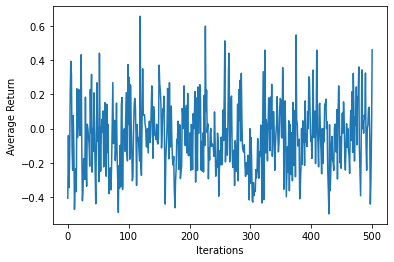

In [23]:
import matplotlib.pyplot as plt
plt.plot(return_data)
plt.xlabel("Iterations")
plt.ylabel("Average Return")